In [37]:
# importing required packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
%matplotlib inline
import warnings
warnings.filterwarnings(action = 'ignore')

In [38]:
def heading(info):
    print("\n\n##### {} #####".format(info))

In [39]:
# read the dataset
dataSet = pd.read_csv('Banglore_traffic_Dataset.csv', encoding = 'unicode_escape')

In [40]:
# print info about the data
dataSet.info()
heading("Sample data points from the dataset")
dataSet.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Date                                8936 non-null   object 
 1   Area Name                           8936 non-null   object 
 2   Road/Intersection Name              8936 non-null   object 
 3   Traffic Volume                      8936 non-null   int64  
 4   Average Speed                       8936 non-null   float64
 5   Travel Time Index                   8936 non-null   float64
 6   Congestion Level                    8936 non-null   float64
 7   Road Capacity Utilization           8936 non-null   float64
 8   Incident Reports                    8936 non-null   int64  
 9   Environmental Impact                8936 non-null   float64
 10  Public Transport Usage              8936 non-null   float64
 11  Traffic Signal Compliance           8936 no

,Date,Area Name,Road/Intersection Name,Traffic Volume,Average Speed,Travel Time Index,Congestion Level,Road Capacity Utilization,Incident Reports,Environmental Impact,Public Transport Usage,Traffic Signal Compliance,Parking Usage,Pedestrian and Cyclist Count,Weather Conditions,Roadwork and Construction Activity
0,2022-01-01,Indiranagar,100 Feet Road,50590,50.230299,1.500000,100.000000,100.000000,0,151.180,70.632330,84.044600,85.403629,111,Clear,No
1,2022-01-01,Indiranagar,CMH Road,30825,29.377125,1.500000,100.000000,100.000000,1,111.650,41.924899,91.407038,59.983689,100,Clear,No
2,2022-01-01,Whitefield,Marathahalli Bridge,7399,54.474398,1.039069,28.347994,36.396525,0,64.798,44.662384,61.375541,95.466020,189,Clear,No
3,2022-01-01,Koramangala,Sony World Junction,60874,43.817610,1.500000,100.000000,100.000000,1,171.748,32.773123,75.547092,63.567452,111,Clear,No
4,2022-01-01,Koramangala,Sarjapur Road,57292,41.116763,1.500000,100.000000,100.000000,3,164.584,35.092601,64.634762,93.155171,104,Clear,No


In [41]:
# lets find the individual column statistics
heading("Stats about non-numeric values")
print(dataSet.describe(include = "object"))

heading("Stats about numeric values")
print(dataSet.describe(include = "number"))



##### Stats about non-numeric values #####
              Date    Area Name Road/Intersection Name Weather Conditions  \
count         8936         8936                   8936               8936   
unique         952            8                     16                  5   
top     2023-01-24  Indiranagar          100 Feet Road              Clear   
freq            15         1720                    860               5426   

       Roadwork and Construction Activity  
count                                8936  
unique                                  2  
top                                    No  
freq                                 8054  


##### Stats about numeric values #####
       Traffic Volume  Average Speed  Travel Time Index  Congestion Level  \
count     8936.000000    8936.000000        8936.000000       8936.000000   
mean     29236.048120      39.447427           1.375554         80.818041   
std      13001.808801      10.707244           0.165319         23.533182   




##### Target variable "Traffic volume" distribution #####


<Axes: xlabel='Traffic Volume', ylabel='Count'>

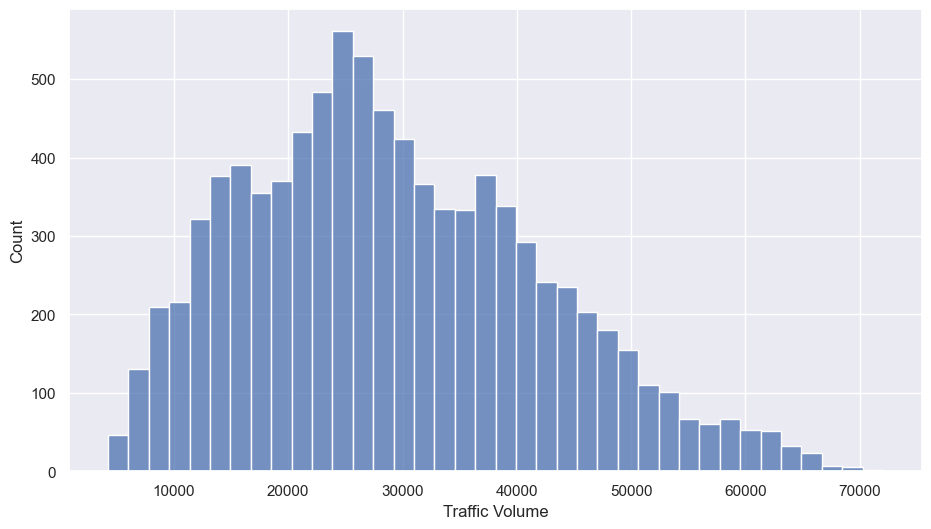

In [42]:
# lets first verify how to target variable is distributed
heading("Target variable \"Traffic volume\" distribution")
sns.histplot(data = dataSet, x = "Traffic Volume")

<Axes: >

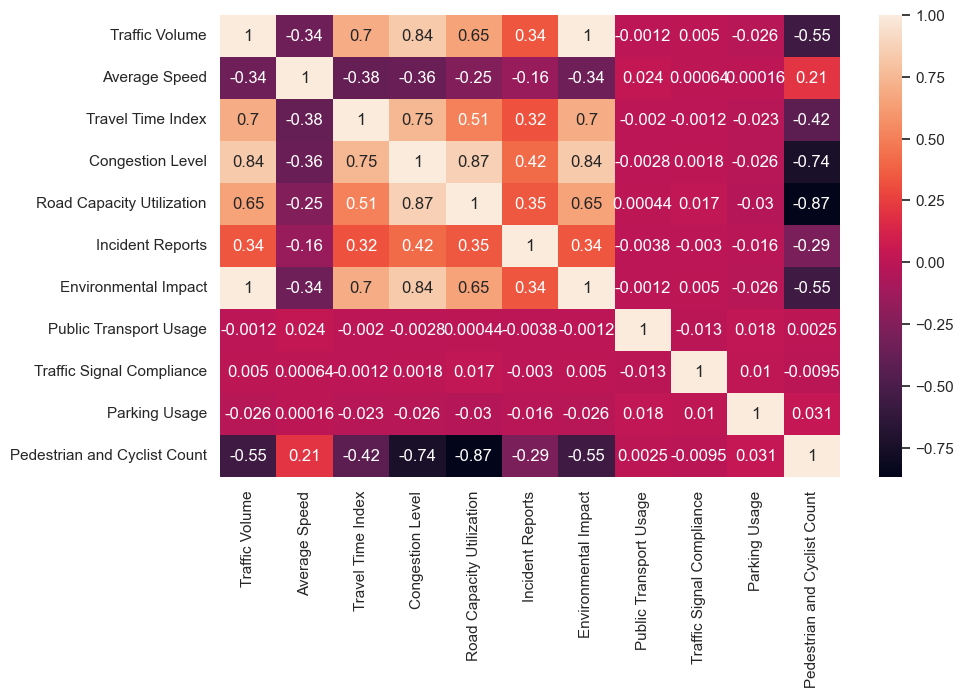

In [43]:
# lets also plot the corelation heatmap to analyze how to variables are co-related.
sns.set(rc = {'figure.figsize': (10,6)})
corelations = dataSet.select_dtypes(include = "number").corr()
sns.heatmap(corelations, annot = True)

## Some observations

### general dataset
- total 8936 values
- 15 input variables, 1 target variable
- none of them have nan/null values
- 5 non numeric variables, 3 integer variables, 8 floats

### non numeric
- date has 952 unique values
- rest have 8,16,5 and2 unique values
- need to be converted into numeric type

### misc
- target variable is little skewd version of normal distribution
- From the corelation heatmap above: Public Transport Usage, Traffic Signal Compliance, Parking Usage have very less corelation with the target variable

In [44]:
# lets convert the categorical values to numeric
def convert_categorical_to_numeric(dataframe, categorical_cols):
    
    for col in categorical_cols:
        if col in dataframe.columns:
            # create a mapping for the unique values in the column
            unique_values = dataframe[col].unique()
            value_mapping = {label: idx for idx, label in enumerate(unique_values)}
            
            # apply the mapping to convert to numeric
            dataframe[col] = [value_mapping[val] for val in dataframe[col]]
    
    return dataframe

# leaving date column as of now and converting other columns

# we will backup the original dataset 
originalDataset = dataSet.copy()

# select the relevant columns and convert them
columnsToConvert = ["Roadwork and Construction Activity","Weather Conditions","Area Name","Road/Intersection Name"]
dataSet = convert_categorical_to_numeric(dataSet, columnsToConvert)

heading("After conversion to numeric values")
print(dataSet[columnsToConvert].head())



##### After conversion to numeric values #####
   Roadwork and Construction Activity  Weather Conditions  Area Name  \
0                                   0                   0          0   
1                                   0                   0          0   
2                                   0                   0          1   
3                                   0                   0          2   
4                                   0                   0          2   

   Road/Intersection Name  
0                       0  
1                       1  
2                       2  
3                       3  
4                       4  


<Axes: >

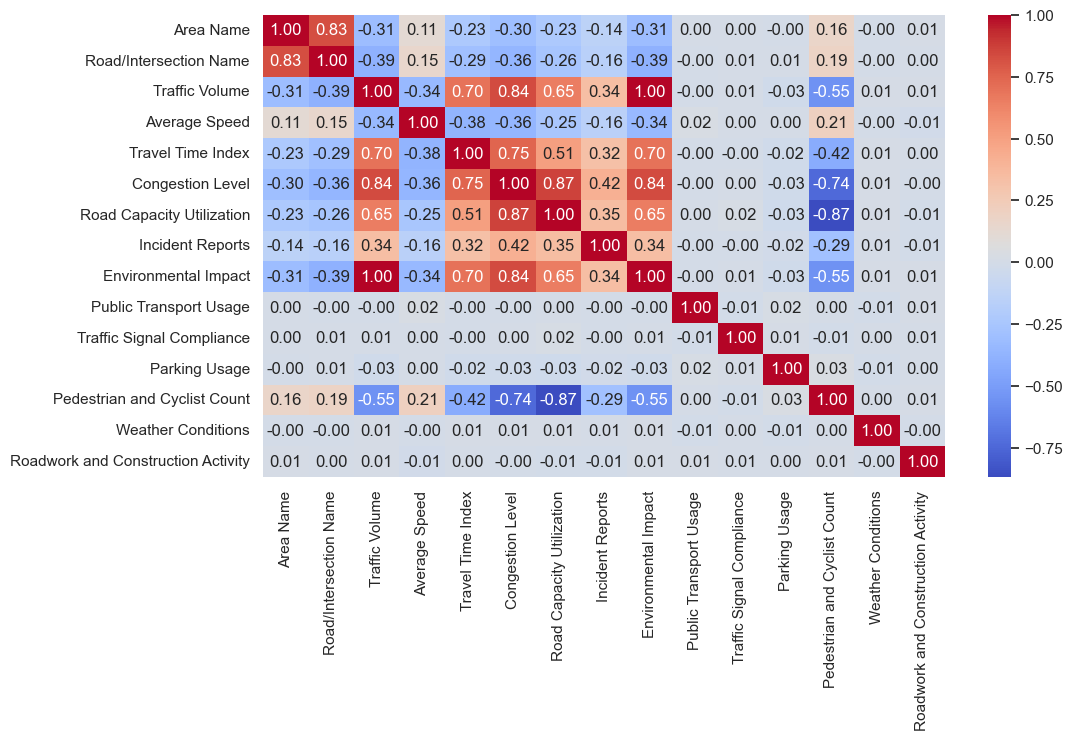

In [45]:
# lets again plot the corelation heatmap to analyze how all the variables are co-related.
sns.set(rc = {'figure.figsize': (11,6)})
corelations = dataSet.select_dtypes(include = "number").corr()
sns.heatmap(corelations, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

<Axes: >

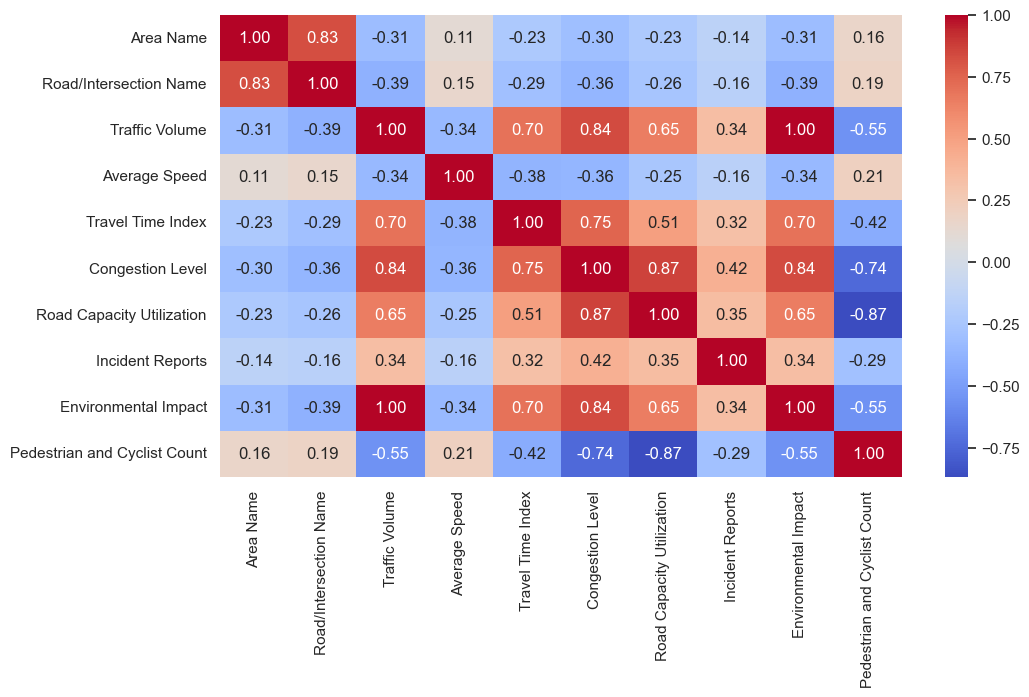

In [46]:
# we will drop certain columns that do not corelate to our target variable
dropThem = ["Public Transport Usage", "Traffic Signal Compliance", "Parking Usage", "Roadwork and Construction Activity","Weather Conditions"]
corelations = corelations.drop(columns=dropThem, index=dropThem)
sns.heatmap(corelations, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

In [32]:
y = dataSet["Traffic Volume"]
dataSet = dataSet.drop(columns=dropThem)

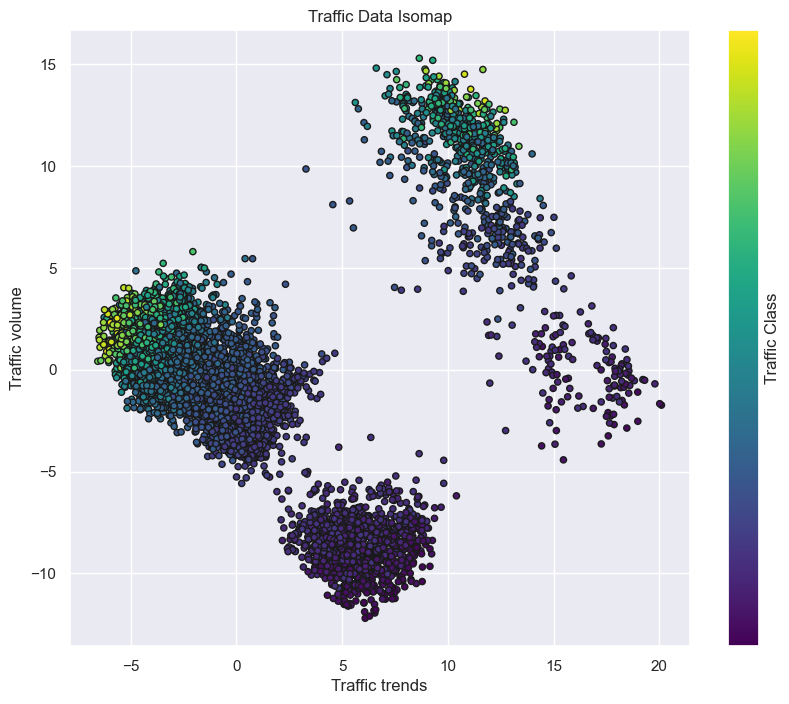

In [48]:
dataSet = convert_categorical_to_numeric(dataSet,['Date'])
X = dataSet.drop(columns=["Traffic Volume"])
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

reduction_map = Isomap(n_neighbors=X.shape[1], n_components=2)
X_reduced = reduction_map.fit_transform(X_std)

plt.figure(figsize=(10, 8))
scatterplot = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', edgecolors='k', s=20)
plt.title('Traffic Data Isomap')
plt.xlabel('Traffic trends')
plt.ylabel('Traffic volume')
plt.colorbar(scatterplot, ticks=np.arange(10), label='Traffic Class')

plt.show()
